Ratio Prediction - Reported & Incremental Average

Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.319  1.099  1.035  1.001  0.991  0.992  0.993   1.020      NaN   
2011  1.368  1.110  1.033  1.004  0.995  0.987  0.998   1.047     1.01   
2012  1.477  1.113  1.035  0.996  0.993  1.003  1.003   0.993     1.01   
2013  1.345  1.145  1.028  0.996  0.995  0.998  0.990   1.006     1.02   
2014  1.507  1.149  1.034  1.009  1.002  0.996  0.990   0.994     0.99   

      120→132  132→144  144→156  156→Ult  
2010      NaN      NaN      NaN      NaN  
2011      NaN      NaN      NaN      NaN  
2012    0.981      NaN      NaN      NaN  
2013    1.025    1.019      NaN      NaN  
2014    0.994    0.992     0.99      NaN  

Detected Outliers:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN    NaN    NaN    NaN  0.991    NaN    NaN     NaN      NaN   
2011    NaN    NaN    NaN    NaN    NaN  0.987    NaN   1.047      NaN   
2013    NaN    NaN  1.028    NaN    

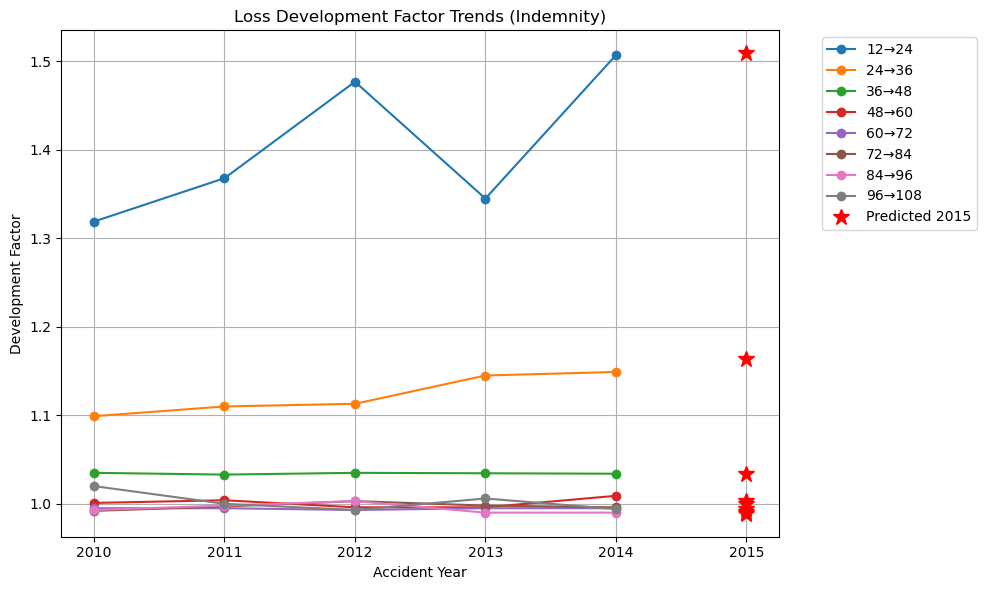

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.319, 1.099, 1.035, 1.001, 0.991, 0.992, 0.993, 1.020, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [1.368, 1.110, 1.033, 1.004, 0.995, 0.987, 0.998, 1.047, 1.010, np.nan, np.nan, np.nan, np.nan],
    2012: [1.477, 1.113, 1.035, 0.996, 0.993, 1.003, 1.003, 0.993, 1.010, 0.981, np.nan, np.nan, np.nan],
    2013: [1.345, 1.145, 1.028, 0.996, 0.995, 0.998, 0.990, 1.006, 1.020, 1.025, 1.019, np.nan, np.nan],
    2014: [1.507, 1.149, 1.034, 1.009, 1.002, 0.996, 0.990, 0.994, 0.990, 0.994, 0.992, 0.990, np.nan]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)
outliers = df[outlier_mask]

print("Detected Outliers:")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 3. Replace Outliers with NaN, then fill with Median
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.median()), axis=0)

print("Cleaned Triangle (Outliers replaced with median):")
print(clean_df)
print()

# ------------------------------
# 4. Predict next (future) year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)       # shape (n_samples, 1)
future_year = np.array([clean_df.index.max() + 1])    # 1D array, will reshape for prediction

predicted_ratios = []
for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    # Only fit if at least 2 data points exist
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]  # reshape to (1,1)
    predicted_ratios.append(pred)

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year:")
print(predicted_row.round(3))
print()

# ------------------------------
# 5. Visualize the trends and prediction
# ------------------------------
plt.figure(figsize=(10, 6))

# Only plot columns with enough data
for col in clean_df.columns[:8]:  # adjust range if needed
    plt.plot(clean_df.index, clean_df[col], marker='o', label=col)

# Plot predictions for the next year
plt.plot([future_year[0]]*8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')


plt.title("Loss Development Factor Trends (Indemnity)")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


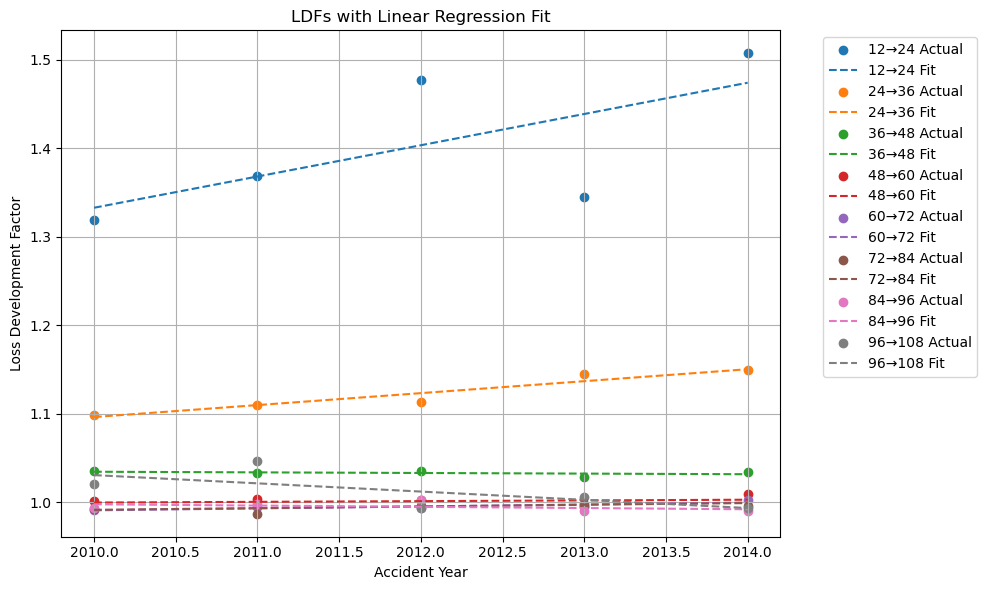

 MAE / RMSE Summary:
Average MAE: 0.009410
Average RMSE: 0.009410
Worst MAE: 0.042840
Worst RMSE: 0.055634
Worst column: 12→24


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# Example LDF triangle data
# -----------------------------
data = {
    2010: [1.319, 1.099, 1.035, 1.001, 0.991, 0.992, 0.993, 1.020],
    2011: [1.368, 1.110, 1.033, 1.004, 0.995, 0.987, 0.998, 1.047],
    2012: [1.477, 1.113, 1.035, 0.996, 0.993, 1.003, 1.003, 0.993],
    2013: [1.345, 1.145, 1.028, 0.996, 0.995, 0.998, 0.990, 1.006],
    2014: [1.507, 1.149, 1.034, 1.009, 1.002, 0.996, 0.990, 0.994]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96", "96→108"]
df = pd.DataFrame(data).T
df.columns = cols

# -----------------------------
# Regression & error metrics
# -----------------------------
years = np.array(df.index).reshape(-1, 1)
mae_list = []
rmse_list = []

plt.figure(figsize=(10, 6))

for col in df.columns:
    y = df[col].values
    x = years
    
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    
    # Calculate MAE and RMSE
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    # Plot actual points
    plt.scatter(x, y, label=f"{col} Actual")
    # Plot regression line directly
    plt.plot(x, y_pred, '--', label=f"{col} Fit")
    
plt.title("LDFs with Linear Regression Fit")
plt.xlabel("Accident Year")
plt.ylabel("Loss Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Average metrics (excluding worst) & worst
# -----------------------------
# Convert to array for easy indexing
mae_array = np.array(mae_list)
rmse_array = np.array(rmse_list)

# Identify worst by RMSE
worst_idx = np.argmax(rmse_array)
worst_mae = mae_array[worst_idx]
worst_rmse = rmse_array[worst_idx]

# Average 
avg_mae = np.mean(mae_array)
avg_rmse = np.mean(mae_array)

print(" MAE / RMSE Summary:")
print(f"Average MAE: {avg_mae:.6f}")
print(f"Average RMSE: {avg_rmse:.6f}")
print(f"Worst MAE: {worst_mae:.6f}")
print(f"Worst RMSE: {worst_rmse:.6f}")
print(f"Worst column: {df.columns[worst_idx]}")



Ratio Prediction - Paid & Incremental Average

Original Paid Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  2.657  1.508  1.212  1.115  1.060  1.030  1.015   1.025      NaN   
2011  2.735  1.550  1.236  1.137  1.066  1.032  1.022   1.037    1.023   
2012  3.266  1.546  1.230  1.118  1.057  1.040  1.025   1.003    1.014   
2013  2.885  1.554  1.236  1.117  1.061  1.030  1.017   1.024    1.026   
2014  2.869  1.534  1.236  1.115  1.060  1.027  1.015   1.012    1.011   

      120→132  132→144  144→156  156→Ult  
2010      NaN      NaN      NaN      NaN  
2011      NaN      NaN      NaN      NaN  
2012    1.000      NaN      NaN      NaN  
2013    1.035    1.021      NaN      NaN  
2014    1.012    1.019    1.007      NaN  

Detected Outliers in Paid Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN  1.508  1.212    NaN    NaN    NaN    NaN     NaN      NaN   
2011    NaN    NaN    NaN  1.137  1.066    NaN    NaN     NaN      NaN   
2012  3.266   

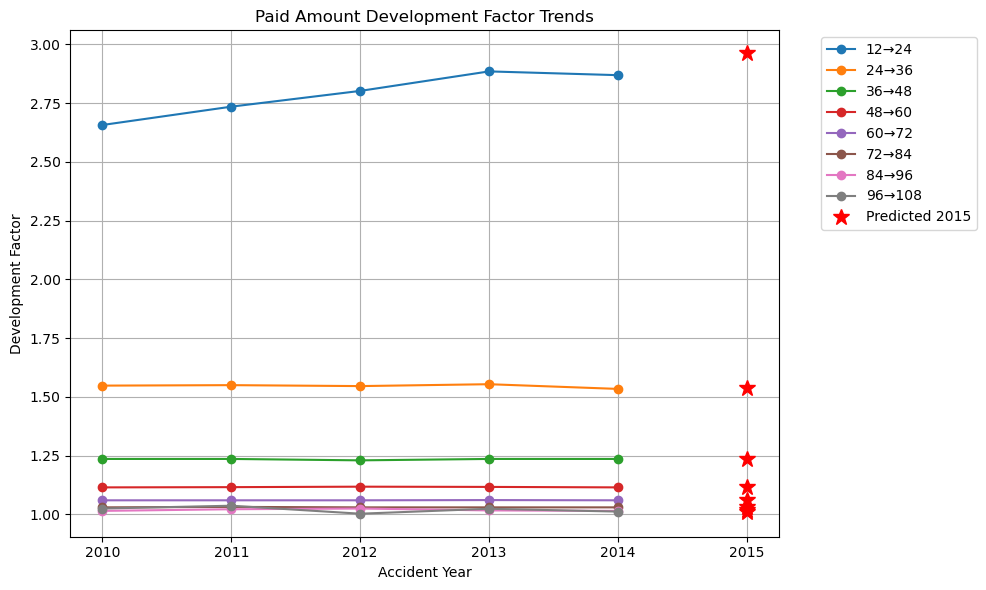

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the "paid amount" triangle
# ------------------------------
data_paid = {
    2010: [2.657, 1.508, 1.212, 1.115, 1.060, 1.030, 1.015, 1.025, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [2.735, 1.550, 1.236, 1.137, 1.066, 1.032, 1.022, 1.037, 1.023, np.nan, np.nan, np.nan, np.nan],
    2012: [3.266, 1.546, 1.230, 1.118, 1.057, 1.040, 1.025, 1.003, 1.014, 1.000, np.nan, np.nan, np.nan],
    2013: [2.885, 1.554, 1.236, 1.117, 1.061, 1.030, 1.017, 1.024, 1.026, 1.035, 1.021, np.nan, np.nan],
    2014: [2.869, 1.534, 1.236, 1.115, 1.060, 1.027, 1.015, 1.012, 1.011, 1.012, 1.019, 1.007, np.nan]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df_paid = pd.DataFrame(data_paid).T
df_paid.columns = cols

print("Original Paid Triangle:")
print(df_paid)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df_paid.apply(find_outliers)
outliers = df_paid[outlier_mask]

print("Detected Outliers in Paid Triangle:")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 3. Replace Outliers with NaN, then fill with Median
# ------------------------------
clean_paid = df_paid.mask(outlier_mask)
clean_paid = clean_paid.apply(lambda col: col.fillna(col.median()), axis=0)

print("Cleaned Paid Triangle (Outliers replaced with median):")
print(clean_paid)
print()

# ------------------------------
# 4. Predict next year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_paid.index).reshape(-1, 1)
future_year = np.array([clean_paid.index.max() + 1])  # 1D array

predicted_paid = []
for col in clean_paid.columns:
    y = clean_paid[col].values
    mask = ~np.isnan(y)
    
    # Only fit if at least 2 data points exist
    if mask.sum() < 2:
        predicted_paid.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_paid.append(pred)

predicted_row = pd.Series(predicted_paid, index=clean_paid.columns, name=future_year.item())
print("Predicted Paid Ratios for Next Year:")
print(predicted_row.round(3))
print()

# ------------------------------
# 5. Visualize the trends and predictions
# ------------------------------
plt.figure(figsize=(10, 6))

# Plot columns that have data
num_cols_to_plot = min(8, clean_paid.shape[1])  # adjust as needed
for col in clean_paid.columns[:num_cols_to_plot]:
    plt.plot(clean_paid.index, clean_paid[col], marker='o', label=col)

# Plot predicted points
plt.plot([future_year[0]]*num_cols_to_plot, predicted_paid[:num_cols_to_plot], 'r*',
         markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Paid Amount Development Factor Trends")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Predicted Paid Ratios for Next Year:
12→24      2.962
24→36      1.539
36→48      1.235
48→60      1.116
60→72      1.060
72→84      1.030
84→96      1.017
96→108     1.009
108→120    1.015
120→132    1.021
132→144    1.020
144→156    1.007
156→Ult      NaN
Name: 2015, dtype: float64

Average MAE (all columns): 0.00458
Average RMSE (all columns): 0.005564


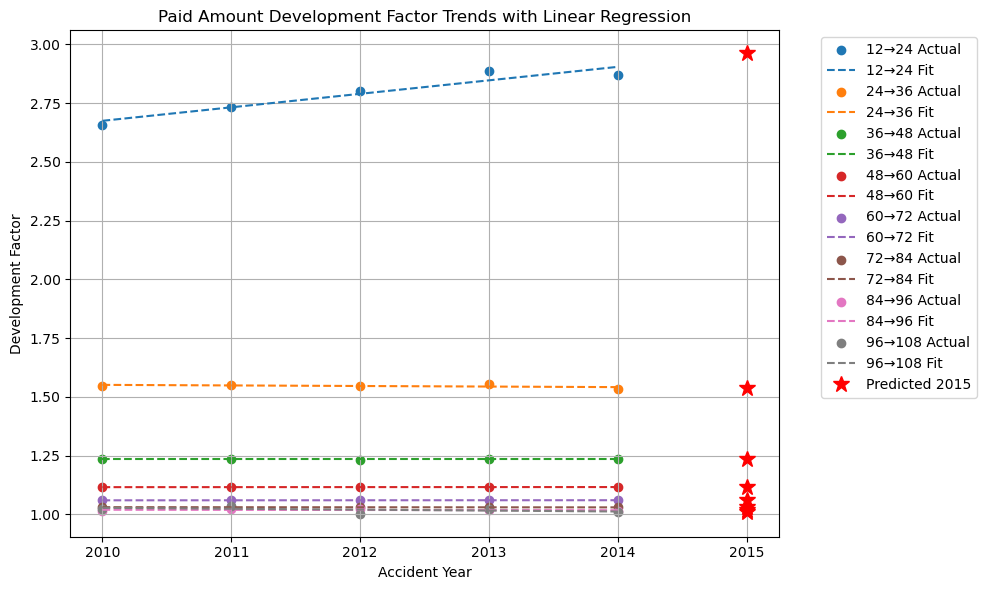

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the "paid amount" triangle
# ------------------------------
data_paid = {
    2010: [2.657, 1.508, 1.212, 1.115, 1.060, 1.030, 1.015, 1.025, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [2.735, 1.550, 1.236, 1.137, 1.066, 1.032, 1.022, 1.037, 1.023, np.nan, np.nan, np.nan, np.nan],
    2012: [3.266, 1.546, 1.230, 1.118, 1.057, 1.040, 1.025, 1.003, 1.014, 1.000, np.nan, np.nan, np.nan],
    2013: [2.885, 1.554, 1.236, 1.117, 1.061, 1.030, 1.017, 1.024, 1.026, 1.035, 1.021, np.nan, np.nan],
    2014: [2.869, 1.534, 1.236, 1.115, 1.060, 1.027, 1.015, 1.012, 1.011, 1.012, 1.019, 1.007, np.nan]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df_paid = pd.DataFrame(data_paid).T
df_paid.columns = cols

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df_paid.apply(find_outliers)
clean_paid = df_paid.mask(outlier_mask)
clean_paid = clean_paid.apply(lambda col: col.fillna(col.median()), axis=0)

# ------------------------------
# 3. Predict next year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_paid.index).reshape(-1, 1)
future_year = np.array([clean_paid.index.max() + 1])  # for predictions

predicted_paid = []
mae_list = []
rmse_list = []

for col in clean_paid.columns:
    y = clean_paid[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_paid.append(np.nan)
        mae_list.append(np.nan)
        rmse_list.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    y_pred = model.predict(years[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    
    predicted_paid.append(pred)
    
    # Calculate MAE and RMSE for this column
    mae_list.append(mean_absolute_error(y[mask], y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y[mask], y_pred)))

predicted_row = pd.Series(predicted_paid, index=clean_paid.columns, name=future_year.item())
print("Predicted Paid Ratios for Next Year:")
print(predicted_row.round(3))
print()

# ------------------------------
# 4. Compute average MAE and RMSE (including all columns)
# ------------------------------
mae_array = np.array(mae_list)
rmse_array = np.array(rmse_list)

avg_mae = np.nanmean(mae_array)
avg_rmse = np.nanmean(rmse_array)

print("Average MAE (all columns):", round(avg_mae, 6))
print("Average RMSE (all columns):", round(avg_rmse, 6))

# ------------------------------
# 5. Visualize the trends and regression lines
# ------------------------------
plt.figure(figsize=(10, 6))
num_cols_to_plot = min(8, clean_paid.shape[1])

for col in clean_paid.columns[:num_cols_to_plot]:
    y = clean_paid[col].values
    model = LinearRegression().fit(years, y)
    y_pred = model.predict(years)
    
    plt.scatter(clean_paid.index, y, label=f"{col} Actual")
    plt.plot(clean_paid.index, y_pred, '--', label=f"{col} Fit")

# Plot predicted points
plt.plot([future_year[0]]*num_cols_to_plot, predicted_paid[:num_cols_to_plot], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Paid Amount Development Factor Trends with Linear Regression")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Medical - Reported & Incremental Average

Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.239  1.001  0.994  0.986  0.994  0.989  1.004   1.057      NaN   
2011  1.263  1.019  1.003  0.984  0.989  0.985  0.994   1.030    1.038   
2012  1.362  1.005  0.990  0.984  0.990  0.983  1.011   1.042    0.998   
2013  1.232  1.057  0.974  0.975  0.992  0.987  0.997   1.030    1.057   
2014  1.334  1.026  0.978  0.996  0.989  0.986  0.997   1.017    1.007   

      120→132  132→144  144→156  156→Ult  
2010      NaN      NaN      NaN      NaN  
2011      NaN      NaN      NaN      NaN  
2012    0.989      NaN      NaN      NaN  
2013    1.022    1.020      NaN      NaN  
2014    1.005    0.991     0.99      NaN  

Detected Outliers:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN    NaN    NaN    NaN    NaN    NaN    NaN   1.057      NaN   
2012    NaN    NaN    NaN    NaN    NaN  0.983    NaN     NaN      NaN   
2013    NaN  1.057    NaN  0.975    

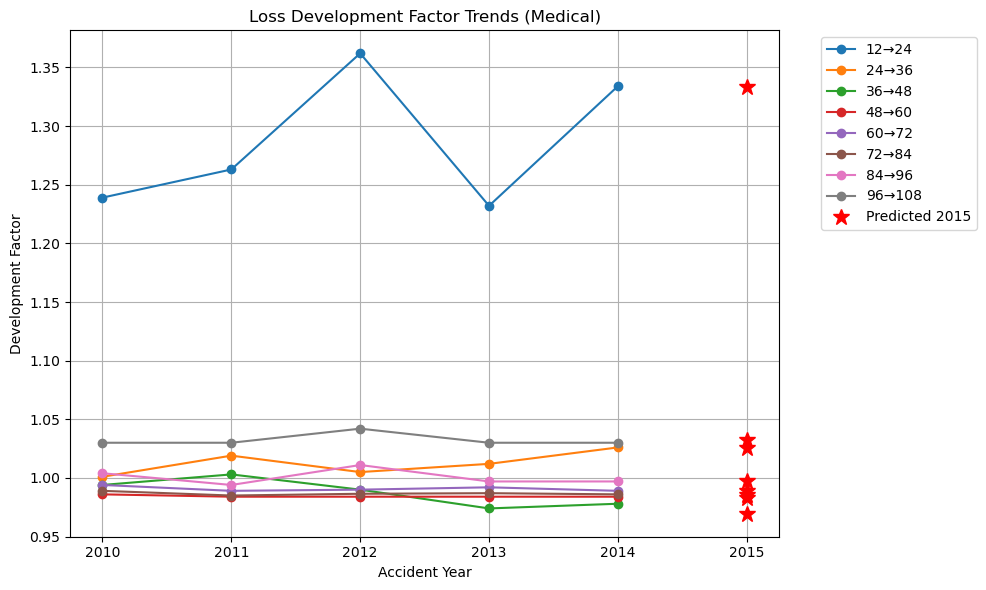

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.239, 1.001, 0.994, 0.986, 0.994, 0.989, 1.004, 1.057, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [1.263, 1.019, 1.003, 0.984, 0.989, 0.985, 0.994, 1.030, 1.038, np.nan, np.nan, np.nan, np.nan],
    2012: [1.362, 1.005, 0.990, 0.984, 0.990, 0.983, 1.011, 1.042, 0.998, 0.989, np.nan, np.nan, np.nan],
    2013: [1.232, 1.057, 0.974, 0.975, 0.992, 0.987, 0.997, 1.030, 1.057, 1.022, 1.020, np.nan, np.nan],
    2014: [1.334, 1.026, 0.978, 0.996, 0.989, 0.986, 0.997, 1.017, 1.007, 1.005, 0.991, 0.990, np.nan]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)
outliers = df[outlier_mask]

print("Detected Outliers:")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 3. Replace Outliers with NaN, then fill with Median
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.median()), axis=0)

print("Cleaned Triangle (Outliers replaced with median):")
print(clean_df)
print()

# ------------------------------
# 4. Predict next (future) year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)       # shape (n_samples, 1)
future_year = np.array([clean_df.index.max() + 1])    # 1D array, will reshape for prediction

predicted_ratios = []
for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    # Only fit if at least 2 data points exist
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]  # reshape to (1,1)
    predicted_ratios.append(pred)

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year:")
print(predicted_row.round(3))
print()

# ------------------------------
# 5. Visualize the trends and prediction
# ------------------------------
plt.figure(figsize=(10, 6))

# Only plot columns with enough data
for col in clean_df.columns[:8]:  # adjust range if needed
    plt.plot(clean_df.index, clean_df[col], marker='o', label=col)

# Plot predictions for the next year
plt.plot([future_year[0]]*8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')


plt.title("Loss Development Factor Trends (Medical)")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Predicted Development Factors for Next Year:
12→24      1.334
24→36      1.026
36→48      0.970
48→60      0.983
60→72      0.989
72→84      0.985
84→96      0.997
96→108     1.032
108→120    1.021
120→132    1.010
132→144    1.001
144→156    0.990
156→Ult      NaN
Name: 2015, dtype: float64

Average MAE (all columns): 0.007718
Average RMSE (all columns): 0.009556


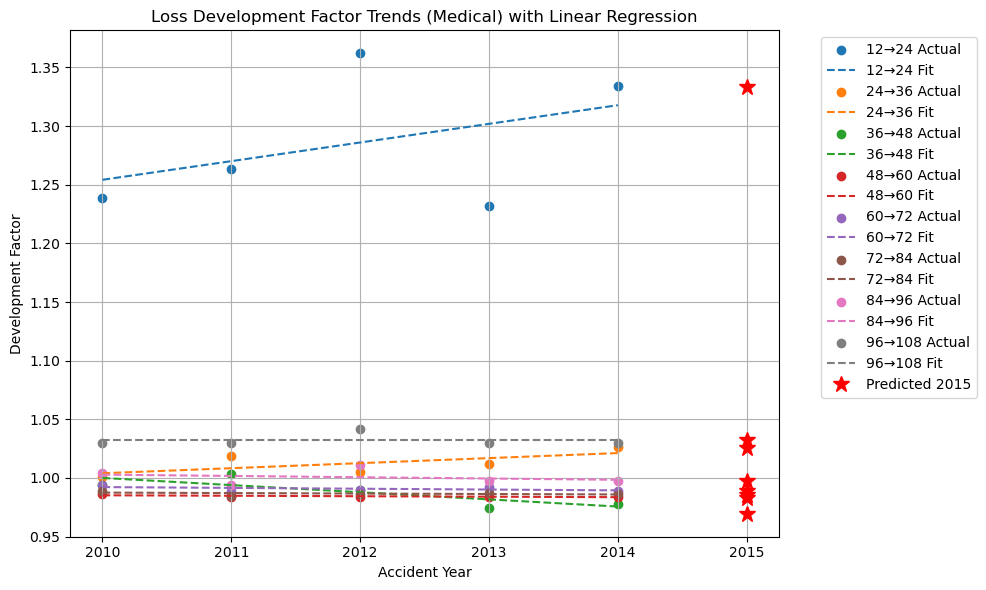

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.239, 1.001, 0.994, 0.986, 0.994, 0.989, 1.004, 1.057, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [1.263, 1.019, 1.003, 0.984, 0.989, 0.985, 0.994, 1.030, 1.038, np.nan, np.nan, np.nan, np.nan],
    2012: [1.362, 1.005, 0.990, 0.984, 0.990, 0.983, 1.011, 1.042, 0.998, 0.989, np.nan, np.nan, np.nan],
    2013: [1.232, 1.057, 0.974, 0.975, 0.992, 0.987, 0.997, 1.030, 1.057, 1.022, 1.020, np.nan, np.nan],
    2014: [1.334, 1.026, 0.978, 0.996, 0.989, 0.986, 0.997, 1.017, 1.007, 1.005, 0.991, 0.990, np.nan]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df = pd.DataFrame(data).T
df.columns = cols

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.median()), axis=0)

# ------------------------------
# 3. Predict next year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

predicted_ratios = []
mae_list = []
rmse_list = []

for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        mae_list.append(np.nan)
        rmse_list.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    y_pred = model.predict(years[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    
    predicted_ratios.append(pred)
    
    # MAE and RMSE for this column
    mae_list.append(mean_absolute_error(y[mask], y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y[mask], y_pred)))

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year:")
print(predicted_row.round(3))
print()

# ------------------------------
# 4. Compute average MAE and RMSE including all columns
# ------------------------------
avg_mae = np.nanmean(mae_list)
avg_rmse = np.nanmean(rmse_list)
print("Average MAE (all columns):", round(avg_mae, 6))
print("Average RMSE (all columns):", round(avg_rmse, 6))

# ------------------------------
# 5. Visualize trends with linear regression lines
# ------------------------------
plt.figure(figsize=(10, 6))
num_cols_to_plot = min(8, clean_df.shape[1])

for col in clean_df.columns[:num_cols_to_plot]:
    y = clean_df[col].values
    model = LinearRegression().fit(years, y)
    y_pred = model.predict(years)
    
    plt.scatter(clean_df.index, y, label=f"{col} Actual")
    plt.plot(clean_df.index, y_pred, '--', label=f"{col} Fit")

# Plot predicted points
plt.plot([future_year[0]]*num_cols_to_plot, predicted_ratios[:num_cols_to_plot], 'r*', markersize=12,
         label=f'Predicted {future_year[0]}')

plt.title("Loss Development Factor Trends (Medical) with Linear Regression")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Medical - Paid & Incremental Average

Original Paid Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.913  1.118  1.049  1.022  1.016  1.005  1.003   1.039      NaN   
2011  1.957  1.118  1.039  1.021  1.009  1.006  1.005   1.026    1.037   
2012  2.048  1.114  1.041  1.016  1.008  1.003  1.008   1.019    1.003   
2013  1.961  1.135  1.037  1.015  1.006  1.006  1.003   1.021    1.042   
2014  1.944  1.113  1.094  1.018  1.009  1.002  1.004   1.016    1.009   

      120→132  132→144  144→156  156→Ult  
2010      NaN      NaN      NaN      NaN  
2011      NaN      NaN      NaN      NaN  
2012    1.010      NaN      NaN      NaN  
2013    1.025    1.034      NaN      NaN  
2014    1.026    1.010    1.025      NaN  

Detected Outliers in Paid Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.913    NaN    NaN    NaN  1.016    NaN    NaN   1.039      NaN   
2012  2.048    NaN    NaN    NaN    NaN    NaN  1.008     NaN      NaN   
2013    NaN  1

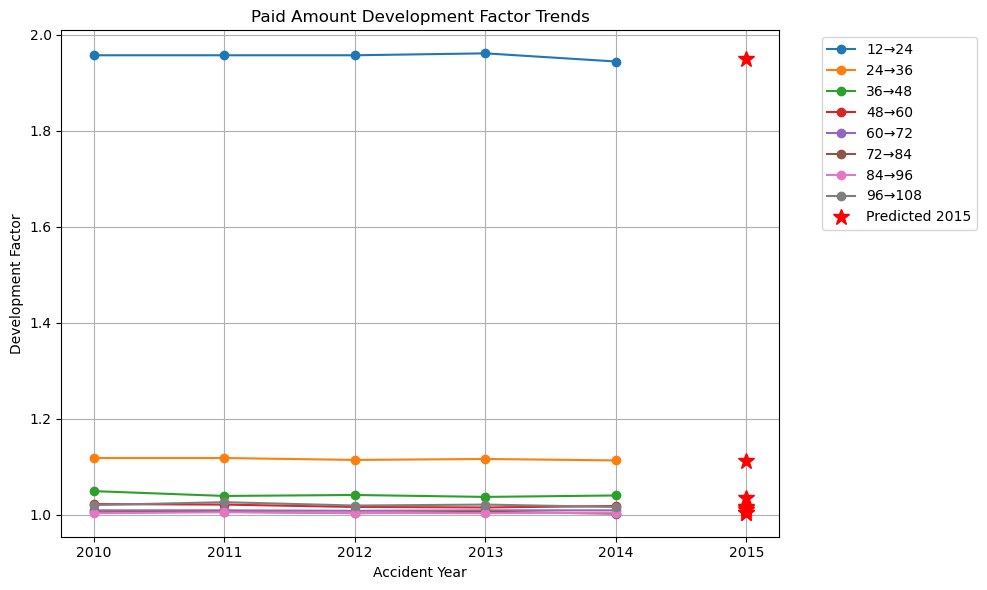

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the "paid amount" triangle
# ------------------------------
data_paid = {
    2010: [1.913, 1.118, 1.049, 1.022, 1.016, 1.005, 1.003, 1.039, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [1.957, 1.118, 1.039, 1.021, 1.009, 1.006, 1.005, 1.026, 1.037, np.nan, np.nan, np.nan, np.nan],
    2012: [2.048, 1.114, 1.041, 1.016, 1.008, 1.003, 1.008, 1.019, 1.003, 1.010, np.nan, np.nan, np.nan],
    2013: [1.961, 1.135, 1.037, 1.015, 1.006, 1.006, 1.003, 1.021, 1.042, 1.025, 1.034, np.nan, np.nan],
    2014: [1.944, 1.113, 1.094, 1.018, 1.009, 1.002, 1.004, 1.016, 1.009, 1.026, 1.010, 1.025, np.nan]
}
cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df_paid = pd.DataFrame(data_paid).T
df_paid.columns = cols

print("Original Paid Triangle:")
print(df_paid)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df_paid.apply(find_outliers)
outliers = df_paid[outlier_mask]

print("Detected Outliers in Paid Triangle:")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 3. Replace Outliers with NaN, then fill with Median
# ------------------------------
clean_paid = df_paid.mask(outlier_mask)
clean_paid = clean_paid.apply(lambda col: col.fillna(col.median()), axis=0)

print("Cleaned Paid Triangle (Outliers replaced with median):")
print(clean_paid)
print()

# ------------------------------
# 4. Predict next year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_paid.index).reshape(-1, 1)
future_year = np.array([clean_paid.index.max() + 1])  # 1D array

predicted_paid = []
for col in clean_paid.columns:
    y = clean_paid[col].values
    mask = ~np.isnan(y)
    
    # Only fit if at least 2 data points exist
    if mask.sum() < 2:
        predicted_paid.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_paid.append(pred)

predicted_row = pd.Series(predicted_paid, index=clean_paid.columns, name=future_year.item())
print("Predicted Paid Ratios for Next Year:")
print(predicted_row.round(3))
print()

# ------------------------------
# 5. Visualize the trends and predictions
# ------------------------------
plt.figure(figsize=(10, 6))

# Plot columns that have data
num_cols_to_plot = min(8, clean_paid.shape[1])  # adjust as needed
for col in clean_paid.columns[:num_cols_to_plot]:
    plt.plot(clean_paid.index, clean_paid[col], marker='o', label=col)

# Plot predicted points
plt.plot([future_year[0]]*num_cols_to_plot, predicted_paid[:num_cols_to_plot], 'r*',
         markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Paid Amount Development Factor Trends")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Predicted Paid Ratios for Next Year:
12→24      1.949
24→36      1.112
36→48      1.035
48→60      1.014
60→72      1.009
72→84      1.003
84→96      1.004
96→108     1.016
108→120    1.016
120→132    1.026
132→144    1.018
144→156    1.025
156→Ult      NaN
Name: 2015, dtype: float64

Average MAE (all columns): 0.002738
Average RMSE (all columns): 0.003223


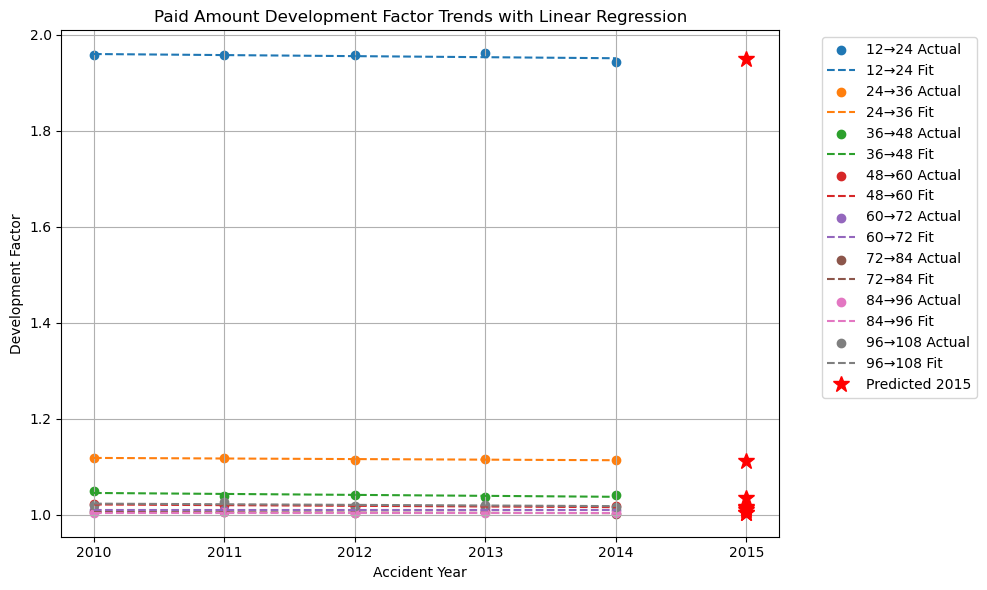

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the "paid amount" triangle
# ------------------------------
data_paid = {
    2010: [1.913, 1.118, 1.049, 1.022, 1.016, 1.005, 1.003, 1.039, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [1.957, 1.118, 1.039, 1.021, 1.009, 1.006, 1.005, 1.026, 1.037, np.nan, np.nan, np.nan, np.nan],
    2012: [2.048, 1.114, 1.041, 1.016, 1.008, 1.003, 1.008, 1.019, 1.003, 1.010, np.nan, np.nan, np.nan],
    2013: [1.961, 1.135, 1.037, 1.015, 1.006, 1.006, 1.003, 1.021, 1.042, 1.025, 1.034, np.nan, np.nan],
    2014: [1.944, 1.113, 1.094, 1.018, 1.009, 1.002, 1.004, 1.016, 1.009, 1.026, 1.010, 1.025, np.nan]
}
cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df_paid = pd.DataFrame(data_paid).T
df_paid.columns = cols

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df_paid.apply(find_outliers)
clean_paid = df_paid.mask(outlier_mask)
clean_paid = clean_paid.apply(lambda col: col.fillna(col.median()), axis=0)

# ------------------------------
# 3. Predict next year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_paid.index).reshape(-1, 1)
future_year = np.array([clean_paid.index.max() + 1])

predicted_paid = []
mae_list = []
rmse_list = []

for col in clean_paid.columns:
    y = clean_paid[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_paid.append(np.nan)
        mae_list.append(np.nan)
        rmse_list.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    y_pred = model.predict(years[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    
    predicted_paid.append(pred)
    
    # MAE and RMSE for this column
    mae_list.append(mean_absolute_error(y[mask], y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y[mask], y_pred)))

predicted_row = pd.Series(predicted_paid, index=clean_paid.columns, name=future_year.item())
print("Predicted Paid Ratios for Next Year:")
print(predicted_row.round(3))
print()

# ------------------------------
# 4. Compute average MAE and RMSE including all columns
# ------------------------------
avg_mae = np.nanmean(mae_list)
avg_rmse = np.nanmean(rmse_list)
print("Average MAE (all columns):", round(avg_mae, 6))
print("Average RMSE (all columns):", round(avg_rmse, 6))

# ------------------------------
# 5. Visualize trends with linear regression lines
# ------------------------------
plt.figure(figsize=(10, 6))
num_cols_to_plot = min(8, clean_paid.shape[1])

for col in clean_paid.columns[:num_cols_to_plot]:
    y = clean_paid[col].values
    model = LinearRegression().fit(years, y)
    y_pred = model.predict(years)
    
    plt.scatter(clean_paid.index, y, label=f"{col} Actual")
    plt.plot(clean_paid.index, y_pred, '--', label=f"{col} Fit")

# Plot predicted points
plt.plot([future_year[0]]*num_cols_to_plot, predicted_paid[:num_cols_to_plot], 'r*', markersize=12,
         label=f'Predicted {future_year[0]}')

plt.title("Paid Amount Development Factor Trends with Linear Regression")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
